In [1]:
# Import libraries
import time as time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use("arviz-darkgrid")

In [3]:
warnings.filterwarnings("ignore")

In [4]:
# Generate data
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

true_intercept = 1
true_slope = 2
sigma = 1

size = 200
x = np.linspace(0, 1, size)
y = true_intercept + true_slope * x + np.random.normal(0, sigma ** 2, size)

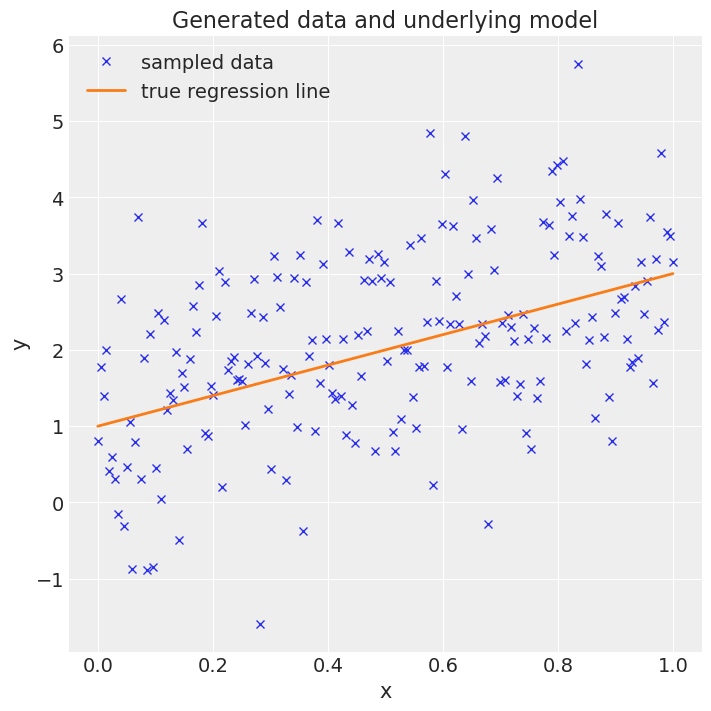

In [7]:
# Plot the data
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x, y, "x", label="sampled data")
ax.plot(x, true_intercept + true_slope * x, label="true regression line", lw=2.0)
plt.legend(loc=0);

## Define the fine model

We choose non-informative Normal priors for both intercept and slope and a Normal likelihood, where we feed in x and y.

In [8]:
# Constructing the fine model
with pm.Model() as fine_model:
    # Define priors
    intercept = pm.Normal("intercept", 0, sigma=20)
    slope = pm.Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + slope * x, sigma=sigma, observed=y)

## Define a coarse model

Here, we define a toy coarse model where coarseness is introduced by using fewer data in the likelihood compared to the fine model, i.e. we only use every 2nd data point from the original data set.

In [13]:
# Thinning the data set
x_coarse = x[::2]
y_coarse = y[::2]
print(f"Original size : {x.shape}")
print(f"Coarse   size : {x_coarse.shape}")

Original size : (200,)
Coarse   size : (100,)


In [14]:
# Constructing the coarse model
with pm.Model() as coarse_model:
    # Define priors
    intercept = pm.Normal("intercept", 0, sigma=20)
    slope = pm.Normal("slope", 0, sigma=20)

    # Define likelihood
    likelihood = pm.Normal("y", mu=intercept + slope * x_coarse, sigma=sigma, observed=y_coarse)

## Draw MCMC samples from the posterior using MLDA

We feed coarse_model to the MLDA instance and we also set subsampling_rate to 10. The subsampling rate is the number of samples drawn in the coarse chain to construct a proposal for the fine chain. In this case, MLDA draws 10 samples in the coarse chain and uses the last one as a proposal for the fine chain. This is accepted or rejected by the fine chain and then control goes back to the coarse chain which generates another 10 samples, etc. Note that pm.MLDA has many other tuning arguments which can be found in the documentation.

Next, we use the universal pm.sample method, passing the MLDA instance to it. This runs MLDA and returns a trace, containing all MCMC samples and various by-products. Here, we also run standard Metropolis and DEMetropolisZ samplers for comparison, which return separate traces. We time the runs to compare later.

In [28]:
with fine_model:
    # Initialise step methods
    step = pm.MLDA(coarse_models=[coarse_model], subsampling_rates=[10])
    step_2 = pm.Metropolis()
    step_3 = pm.DEMetropolisZ()

    # Sample using MLDA
    t_start = time.time()
    trace = pm.sample(draws=6000, chains=4, tune=2000, step=step, random_seed=RANDOM_SEED)
    runtime = time.time() - t_start

    # Sample using Metropolis
    t_start = time.time()
    trace_2 = pm.sample(draws=6000, chains=4, tune=2000, step=step_2, random_seed=RANDOM_SEED)
    runtime_2 = time.time() - t_start

    # Sample using DEMetropolisZ
    t_start = time.time()
    trace_3 = pm.sample(draws=6000, chains=4, tune=2000, step=step_3, random_seed=RANDOM_SEED)
    runtime_3 = time.time() - t_start
print("\nDONE")

Multiprocess sampling (4 chains in 4 jobs)
MLDA: [slope, intercept]


Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 54 seconds.
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [slope]
>Metropolis: [intercept]


Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 31 seconds.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [slope, intercept]


Sampling 4 chains for 2_000 tune and 6_000 draw iterations (8_000 + 24_000 draws total) took 30 seconds.
The number of effective samples is smaller than 25% for some parameters.



DONE


Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>]], dtype=object)

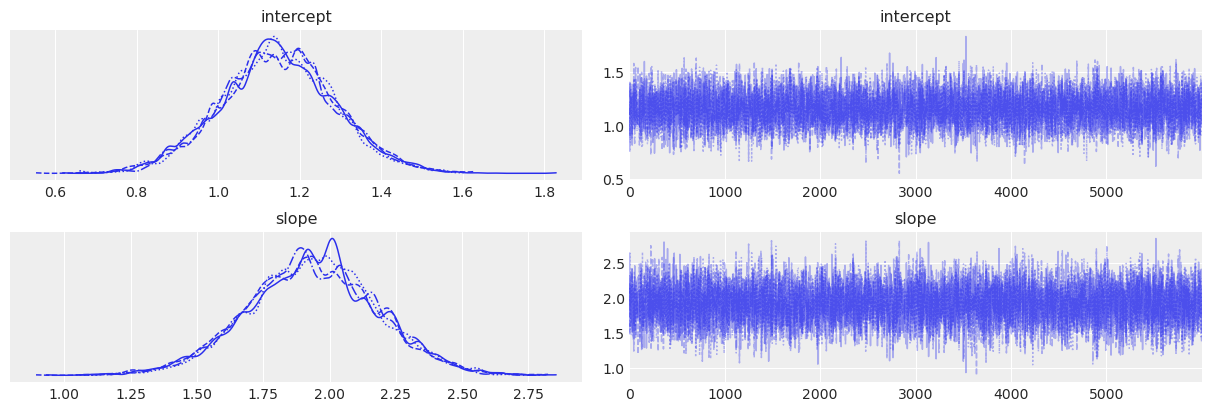

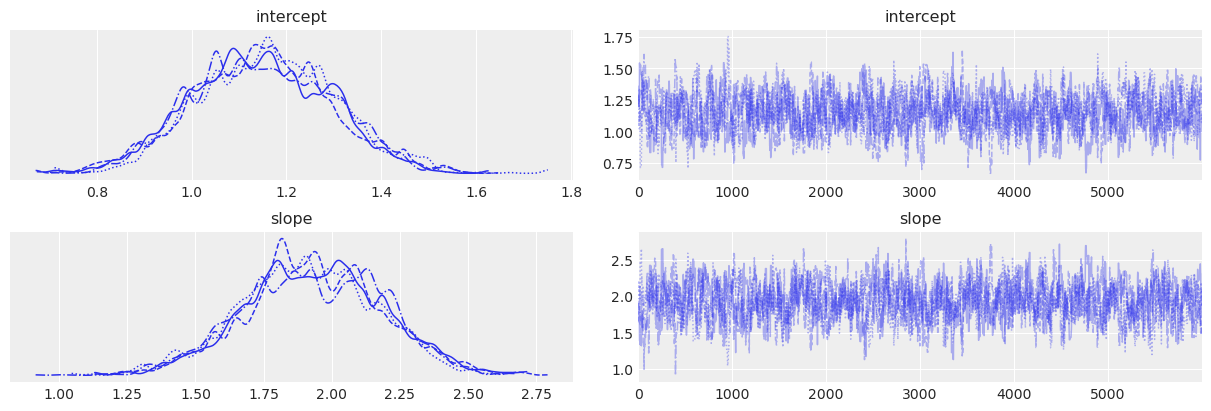

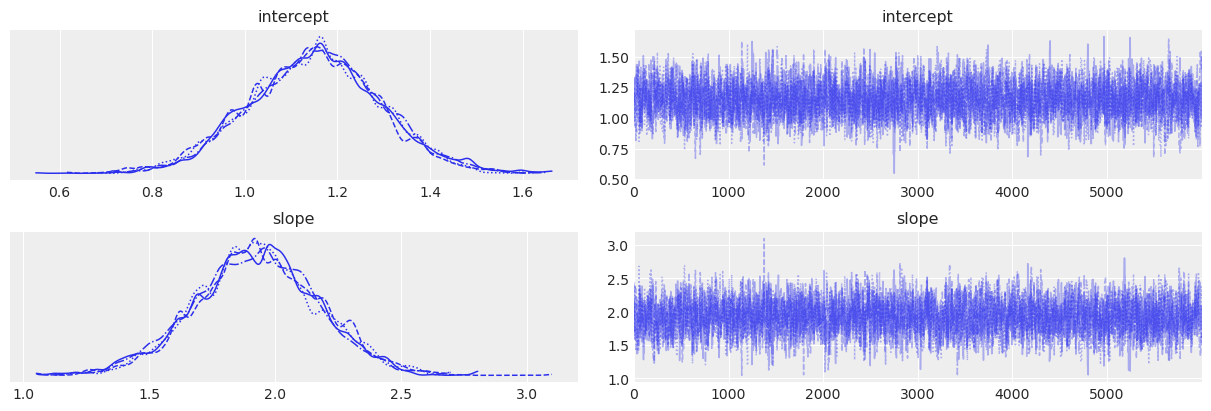

In [29]:
# Trace plots
az.plot_trace(trace)
az.plot_trace(trace_2)
az.plot_trace(trace_3)

In [30]:
# Summary statistics for MLDA
az.summary(trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.146,0.140,0.876,1.406,0.002,0.001,7673.0,7048.0,1.0
slope,1.934,0.244,1.477,2.397,0.003,0.002,7733.0,7577.0,1.0


In [31]:
# Summary statistics for Metropolis
az.summary(trace_2)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.150,0.145,0.875,1.410,0.006,0.004,587.0,1143.0,1.0
slope,1.928,0.251,1.445,2.384,0.010,0.007,596.0,1237.0,1.0


In [32]:
# Summary statistics for DEMetropolisZ
az.summary(trace_3)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.150,0.141,0.886,1.415,0.003,0.002,3007.0,4414.0,1.0
slope,1.926,0.244,1.457,2.381,0.004,0.003,2956.0,4319.0,1.0


In [33]:
# Make sure samplers have converged
assert all(az.rhat(trace) < 1.03)
assert all(az.rhat(trace_2) < 1.03)
assert all(az.rhat(trace_3) < 1.03)

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


In [34]:
print(f"Runtimes: MLDA: {runtime}, Metropolis: {runtime_2}, DEMetropolisZ: {runtime_3}")

Runtimes: MLDA: 54.83877182006836, Metropolis: 32.24099612236023, DEMetropolisZ: 31.117406368255615
